# Dataset preperation

# Enabling GPU

In [1]:
import torch

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name NVIDIA GeForce RTX 4070


# DataLoader


num_train =  8000
num_val =  2000
Img size: torch.Size([224, 224])
Label size: torch.Size([224, 224])
Semua nilai adalah 0 atau 1.


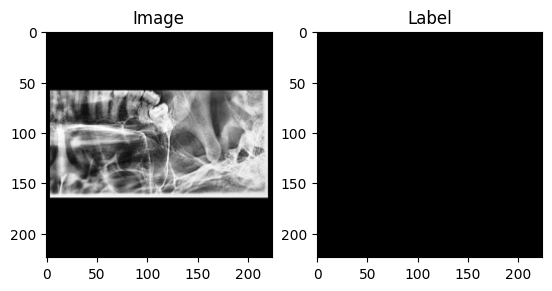

Nilai minimum img: 0.0, Nilai maksimum img: 1.0, Nilai rata-rata img: 0.260454386472702
Nilai minimum label: 0.0, Nilai maksimum label: 0.0, Nilai rata-rata label: 0.0


In [2]:
import glob
import numpy as np

from torchvision.transforms.functional import adjust_gamma
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from preprocessing import *
from helper import *
from PIL import Image


class SimDataset(Dataset):
    def __init__(self, image_path, mask_path):
        # TODO
        # 1. Initialize file paths or a list of file names. 
        self.input_images = glob.glob(str(image_path) + str("/*"))
        self.target_masks = glob.glob(str(mask_path) + str("/*"))
        
    def __len__(self):
        return len(self.target_masks)
        
    def __getitem__(self, idx):
                
        # TODO
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        # 2. Preprocess the data (e.g. torchvision.Transform).
        # 3. Return a data pair (e.g. image and label).
        image = self.input_images[idx]
        img_as_img = Image.open(image)
        img_as_np = np.asarray(img_as_img)

        # Normalize the image
        img_as_np = resize_image(img_as_np, 224, 224)
        img_as_np = clahe_equalized(img_as_np)
        img_as_np = adjust_gamma(img_as_np, 0.9)
        img_as_np = normalization(img_as_np, max=1, min=0)
        img_as_np = np.expand_dims(img_as_np, axis=0)  # add additional dimension
        img_as_tensor = torch.from_numpy(img_as_np).float()  # Convert numpy array to tensor
       
        """
        # GET MASK
        """        
        mask = self.target_masks[idx]
        mask_as_mask = Image.open(mask)

        msk_as_np = np.asarray(mask_as_mask)
        msk_as_np = resize_image(msk_as_np, 224, 224)
        msk_as_np = monochroming_image(msk_as_np)
        msk_as_np = msk_as_np/255
        msk_as_np = np.expand_dims(msk_as_np, axis=0)
        msk_as_tensor = torch.from_numpy(msk_as_np).float()  # Convert numpy array to tensor

        return (img_as_tensor, msk_as_tensor)

train_set = SimDataset('final-dataset/train/images', 'final-dataset/train/masking')
test_set = SimDataset('final-dataset/test/images', 'final-dataset/test/masking')

valid_size = 0.2

n_train = len(train_set)
indices = list(range(n_train))
split = int(np.floor(valid_size * n_train))
np.random.shuffle(indices)

train_idx, val_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

trainloaders = torch.utils.data.DataLoader(train_set, sampler=train_sampler, batch_size=20)
valloaders = torch.utils.data.DataLoader(train_set, sampler=val_sampler, batch_size=10)

print("num_train = ", len(train_sampler))
print("num_val = ", len(val_sampler))

# Display image and label.
train_features, train_labels = next(iter(trainloaders))

# Ambil satu gambar dan label dari batch tersebut
img = train_features[0].squeeze()
label = train_labels[0].squeeze()
print(f"Img size: {img.shape}")
print(f"Label size: {label.shape}")

# Melakukan pengecekan nilai
unique_values = torch.unique(label)
invalid_values = unique_values[(unique_values != 0) & (unique_values != 1)]

if len(invalid_values) > 0:
    print(f'Terdapat nilai yang bukan 0 atau 1: {invalid_values}')
else:
    print('Semua nilai adalah 0 atau 1.')

# Tampilkan gambar dan label
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(img, cmap="gray")
axarr[0].set_title("Image")
axarr[1].imshow(label, cmap="gray")
axarr[1].set_title("Label")
plt.show()

np.set_printoptions(threshold=np.inf)  # Mengatur opsi agar seluruh array dicetak
print(f"Nilai minimum img: {np.min(img.numpy())}, Nilai maksimum img: {np.max(img.numpy())}, Nilai rata-rata img: {np.mean(img.numpy())}")
print(f"Nilai minimum label: {np.min(label.numpy())}, Nilai maksimum label: {np.max(label.numpy())}, Nilai rata-rata label: {np.mean(label.numpy())}")

# Create U-NET Model Function

In [3]:
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

# Train U-NET

In [4]:
from torch.optim import lr_scheduler
import torch.optim as optim
import time
import copy
from collections import defaultdict
from helper import calc_loss, calculate_accuracy

def train_model(model, optimizer, scheduler, num_epochs=100):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    # Plot Evaluation Variable
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        since = time.time()
        print('Epoch {}/{}' .format(epoch+1, num_epochs))

        # Training Process
        scheduler.step()
        model.train()
        metrics = defaultdict(float)
        epoch_samples = 0
        accuracies = []

        for inputs, labels in trainloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)

                # Calc loss
                loss = calc_loss(outputs, labels, metrics)

                # Accuracy
                accuracy = calculate_accuracy(outputs.data, labels.data)
                accuracies.extend(accuracy)

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()
                
            # statistics
            epoch_samples += inputs.size(0)
        
        print_metrics(metrics, epoch_samples, "train")
        train_loss = metrics['loss'] / epoch_samples
        train_losses.append(train_loss)
        train_accuracy = 100 * sum(accuracies) / epoch_samples
        train_accs.append(train_accuracy)
        print('train: Accuracy: {:.6f}%' .format(train_accuracy))

        # Validation Process
        model.eval()
        metrics = defaultdict(float)
        epoch_samples = 0
        accuracies = []
            
        for inputs, labels in valloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
           
            # zero the parameter gradients
            optimizer.zero_grad()

            with torch.no_grad():
                outputs = model(inputs)

                # Calc loss
                loss = calc_loss(outputs, labels, metrics)

                # Accuracy
                accuracy = calculate_accuracy(outputs.data.cpu(), labels.data.cpu())
                accuracies.extend(accuracy)
            
            # statistics
            epoch_samples += inputs.size(0)
        
        print_metrics(metrics, epoch_samples, "val")
        val_loss = metrics['loss'] / epoch_samples
        val_losses.append(val_loss)
        val_accuracy = 100 * sum(accuracies) / epoch_samples
        val_accs.append(val_accuracy)
        print('val: Accuracy: {:.6f}%' .format(val_accuracy))

        if val_loss < best_loss:
            print("=====> saving best model = {} <=====" .format(val_loss))
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'Unet_Model_Splitted_BCE&Dice.pth')

        stop = time.time()
    
        print('Time: {}s\n' .format(stop-since))
        
    # load best model weights
    print('Best val loss: {}'.format(best_loss))
    model.load_state_dict(best_model_wts)
        
    return model, train_losses, val_losses, train_accs,  val_accs

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1
num_epochs = 100
model = UNet(num_class).to(device)

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model, train_loss, val_loss, train_accuracy, val_accuracy= train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

# Plot Loss
f = plt.figure(figsize=(10, 10))
plt.plot(range(1, num_epochs + 1), train_loss, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
f = plt.figure(figsize=(10, 10))
plt.plot(range(1, num_epochs + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

cuda:0
Epoch 1/100


c:\ProgramData\anaconda3\envs\u-net\Lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train: bce: 0.050650, dice: 0.492133, loss: 0.271391
train: Accuracy: 99.915938%
val: bce: 0.013009, dice: 0.445235, loss: 0.229122
val: Accuracy: 99.918756%
=====> saving best model = 0.22912201161438134 <=====
Time: 410.8595356941223s

Epoch 2/100
train: bce: 0.014242, dice: 0.461960, loss: 0.238101
train: Accuracy: 99.915938%
val: bce: 0.014158, dice: 0.444048, loss: 0.229103
val: Accuracy: 99.918756%
=====> saving best model = 0.22910287583246827 <=====
Time: 305.88365268707275s

Epoch 3/100
train: bce: 0.013618, dice: 0.461938, loss: 0.237778
train: Accuracy: 99.915938%
val: bce: 0.013674, dice: 0.444096, loss: 0.228885
val: Accuracy: 99.918756%
=====> saving best model = 0.2288850922510028 <=====
Time: 244.72856879234314s

Epoch 4/100
train: bce: 0.013494, dice: 0.461961, loss: 0.237727
train: Accuracy: 99.915938%
val: bce: 0.011348, dice: 0.446640, loss: 0.228994
val: Accuracy: 99.918756%
Time: 241.7355706691742s

Epoch 5/100
train: bce: 0.013248, dice: 0.461956, loss: 0.237602


# Predict U-NET

cuda:0
num_test =  36


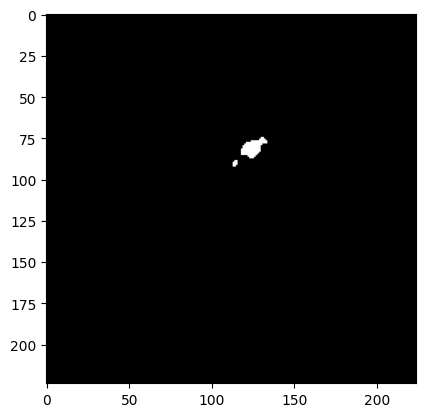

Total Loss: 0.1563226580619812

Recall: 0.6594202898550725
Precission: 0.728
F1-Score: 0.6920152091254753
Accuracy: 0.9983856823979592



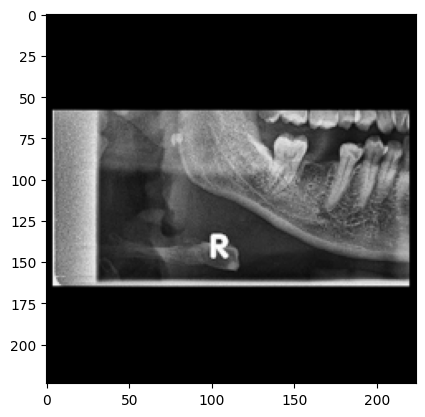

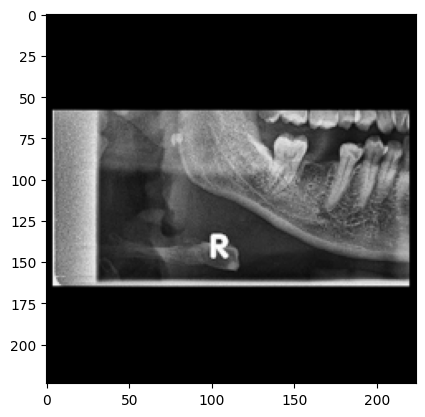

Total Loss: 0.4955616295337677

Recall: 0.0
Precission: 0.0
F1-Score: 0.0
Accuracy: 0.9990433673469388



c:\ProgramData\anaconda3\envs\u-net\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


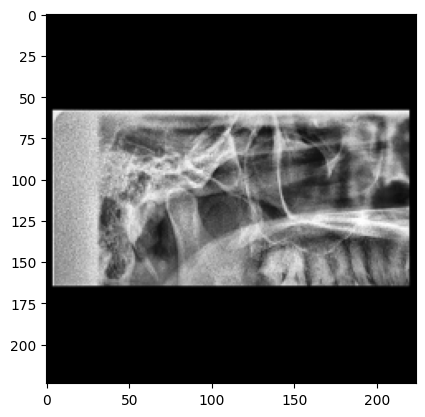

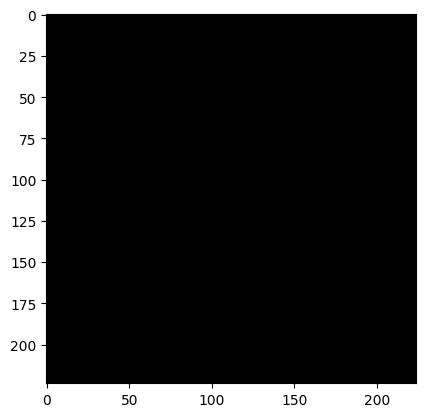

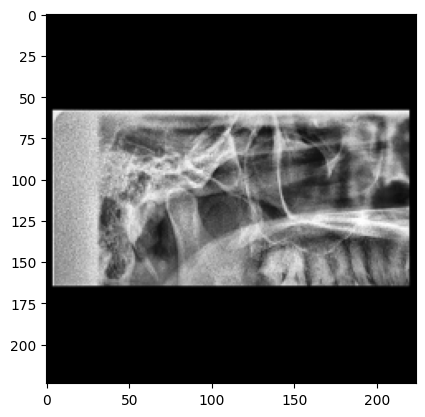

Total Loss: 0.5020495653152466

Recall: 0.0
Precission: 0.0
F1-Score: 0.0
Accuracy: 0.9987643494897959



c:\ProgramData\anaconda3\envs\u-net\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


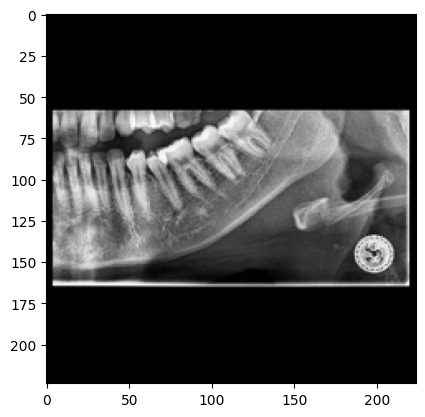

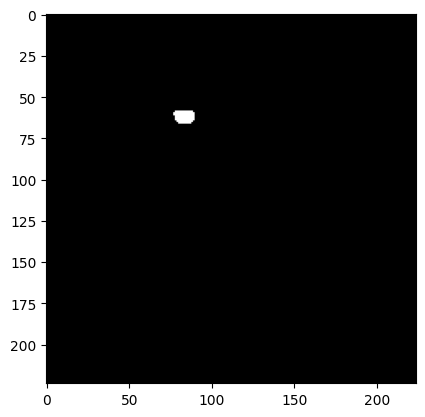

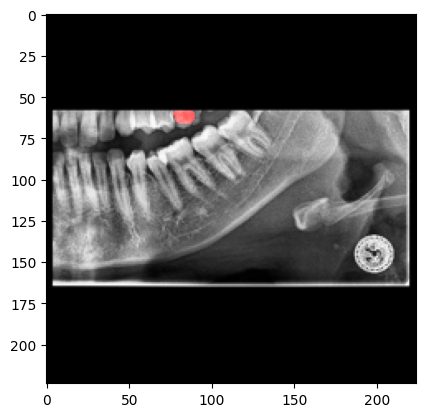

Total Loss: 0.22316694259643555

Recall: 0.6133333333333333
Precission: 0.5054945054945055
F1-Score: 0.5542168674698795
Accuracy: 0.9985251913265306



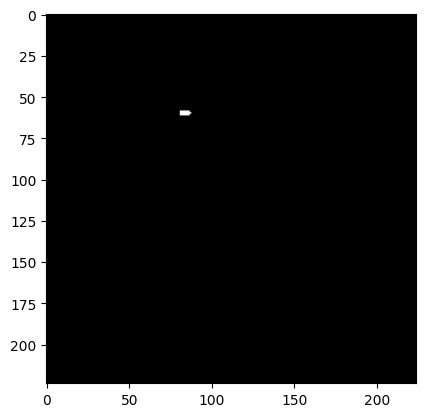

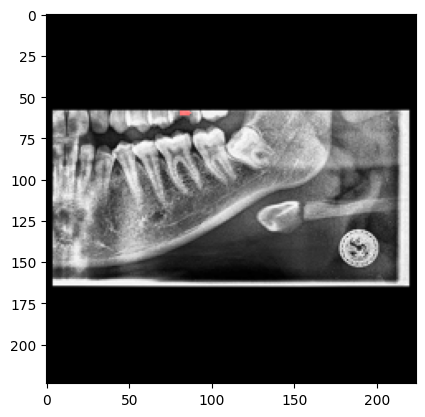

Total Loss: 0.2660816013813019

Recall: 0.2835820895522388
Precission: 1.0
F1-Score: 0.4418604651162791
Accuracy: 0.9990433673469388



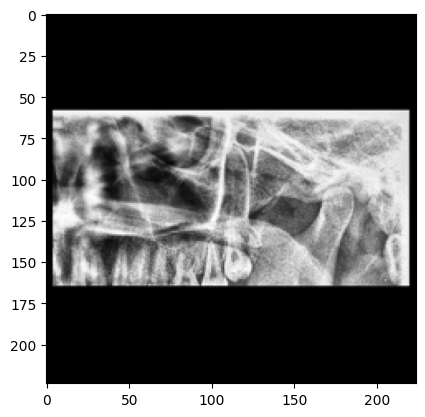

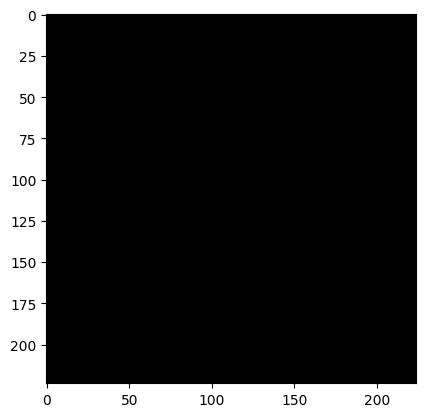

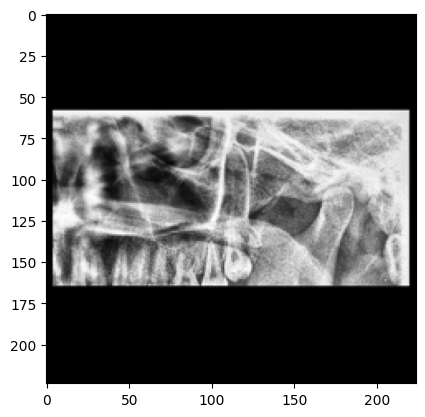

Total Loss: 0.48785313963890076

Recall: 0.0
Precission: 0.0
F1-Score: 0.0
Accuracy: 0.9994220344387755



c:\ProgramData\anaconda3\envs\u-net\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


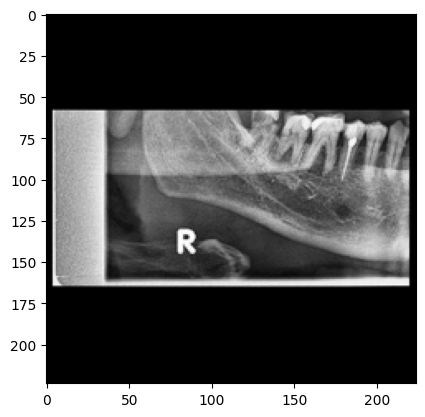

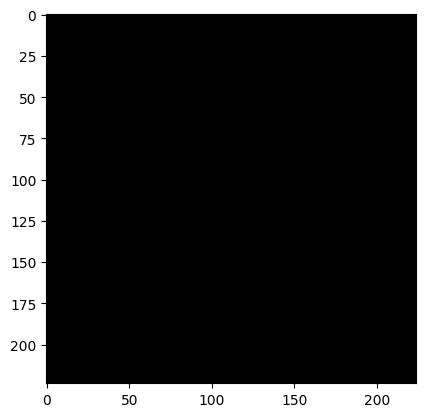

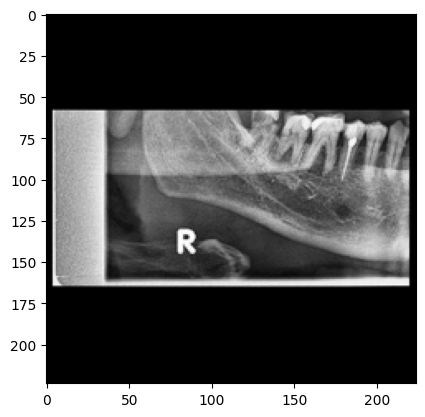

Total Loss: 0.49195611476898193

Recall: 0.0
Precission: 0.0
F1-Score: 0.0
Accuracy: 0.9992426658163265



c:\ProgramData\anaconda3\envs\u-net\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


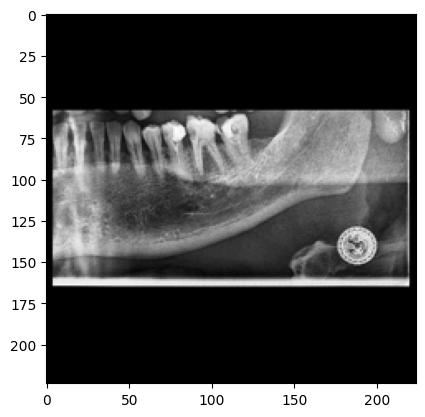

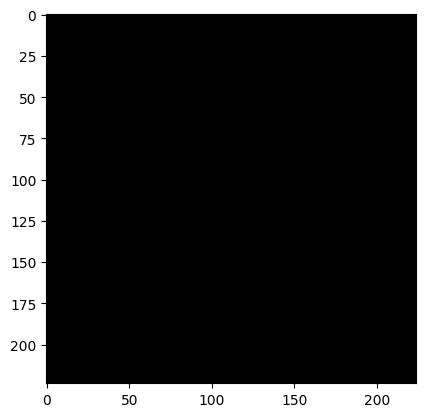

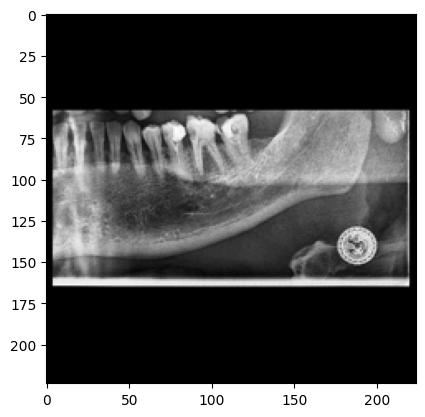

Total Loss: 0.5013336539268494

Recall: 0.0
Precission: 0.0
F1-Score: 0.0
Accuracy: 0.9987444196428571



c:\ProgramData\anaconda3\envs\u-net\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


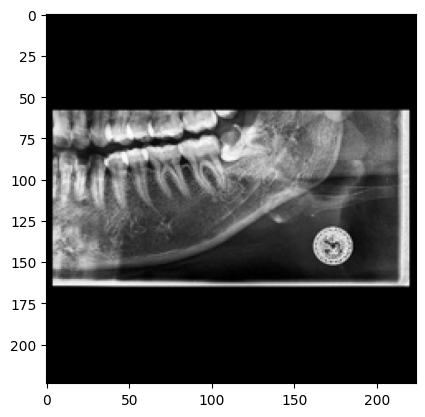

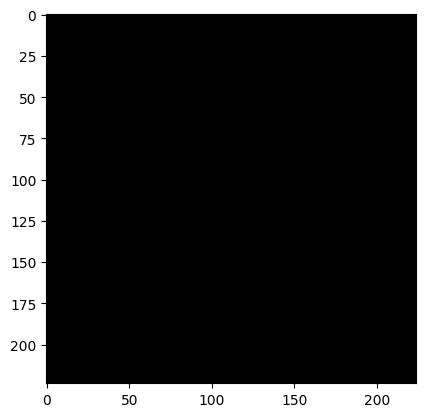

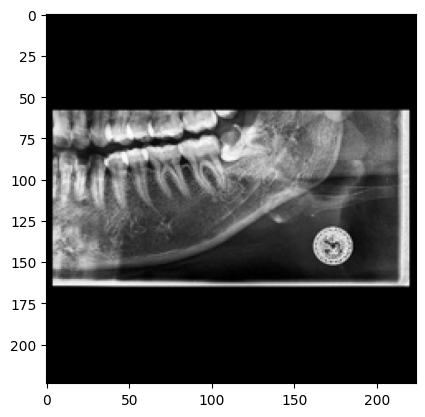

Total Loss: 0.5045026540756226

Recall: 0.0
Precission: 0.0
F1-Score: 0.0
Accuracy: 0.9981465242346939



c:\ProgramData\anaconda3\envs\u-net\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


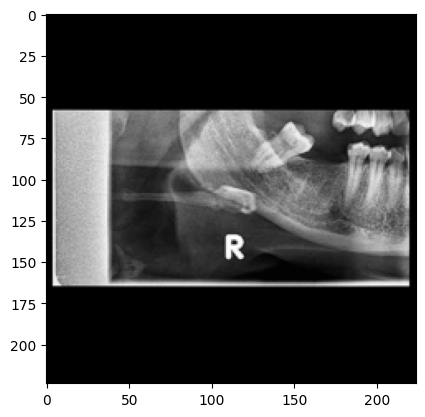

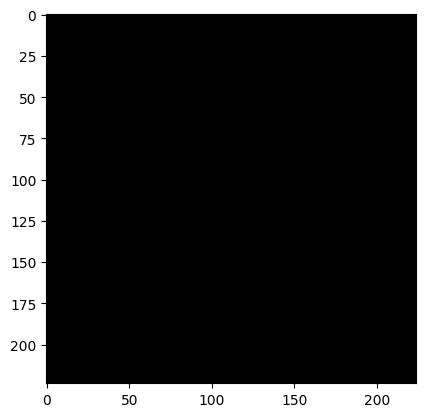

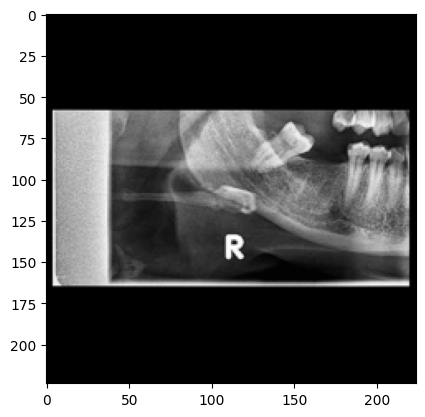

Total Loss: 0.49324384331703186

Recall: 0.0
Precission: 0.0
F1-Score: 0.0
Accuracy: 0.9992426658163265



c:\ProgramData\anaconda3\envs\u-net\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


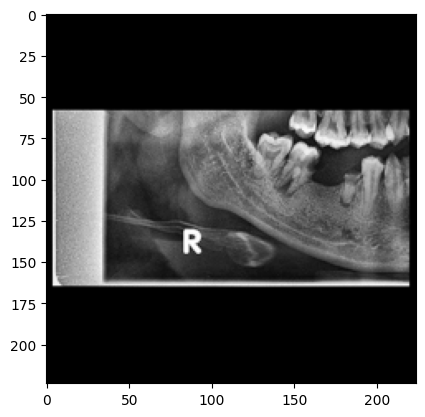

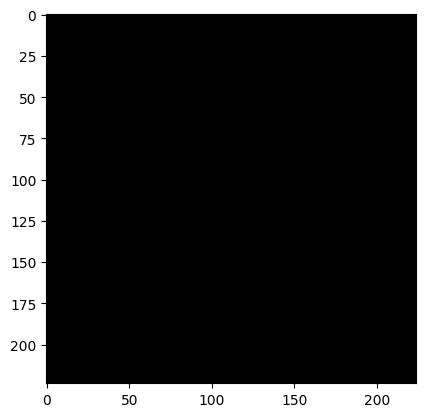

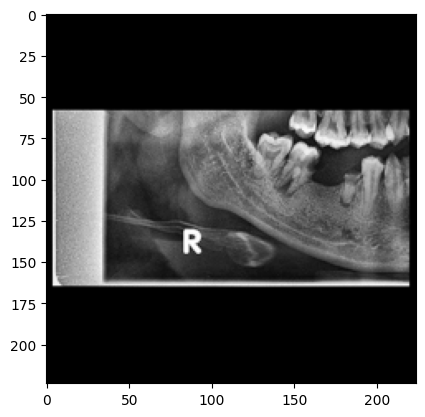

Total Loss: 0.5105757713317871

Recall: 0.0
Precission: 0.0
F1-Score: 0.0
Accuracy: 0.9979870854591837



c:\ProgramData\anaconda3\envs\u-net\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


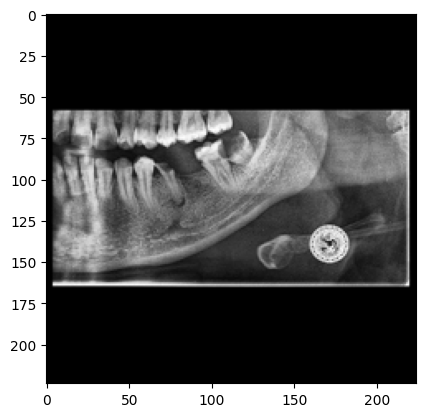

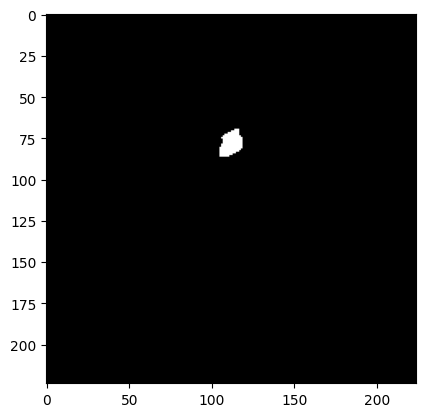

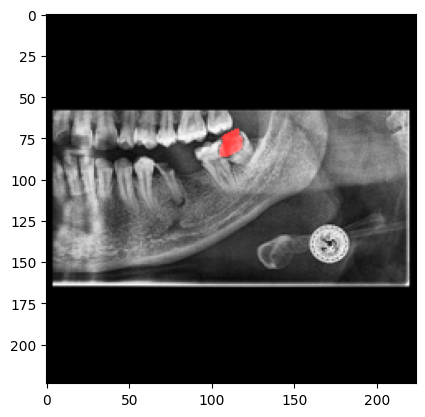

Total Loss: 0.21591170132160187

Recall: 0.7545454545454545
Precission: 0.4797687861271676
F1-Score: 0.5865724381625441
Accuracy: 0.9976682079081632



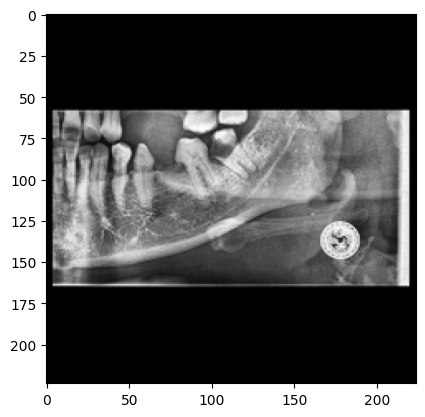

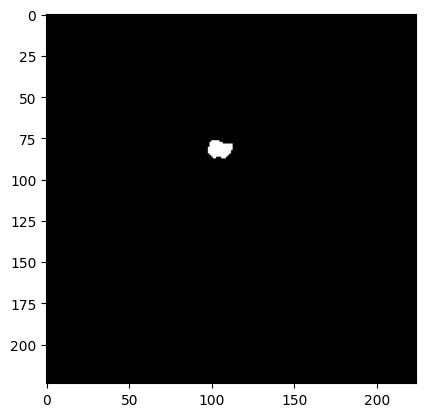

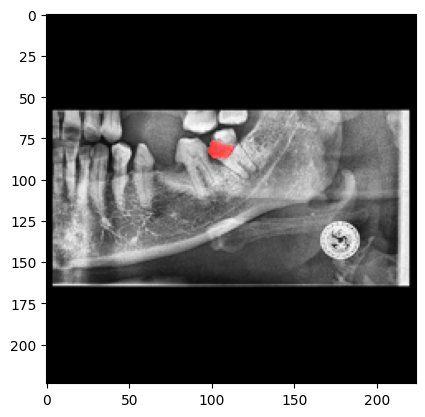

Total Loss: 0.1479172706604004

Recall: 0.6455696202531646
Precission: 0.8095238095238095
F1-Score: 0.7183098591549295
Accuracy: 0.998405612244898



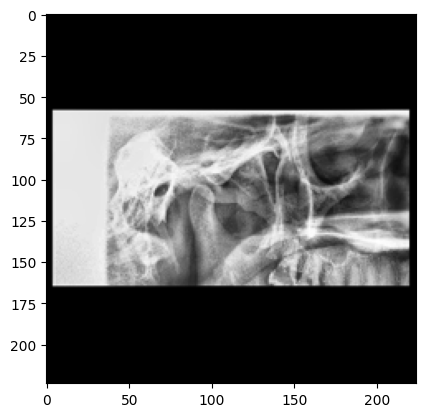

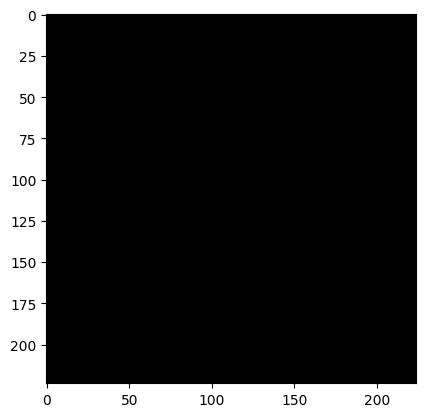

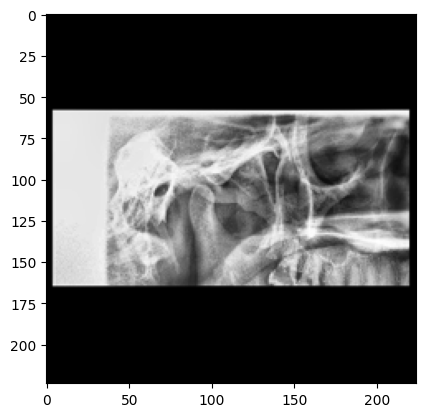

Total Loss: 0.506761372089386

Recall: 0.0
Precission: 0.0
F1-Score: 0.0
Accuracy: 0.9981863839285714



c:\ProgramData\anaconda3\envs\u-net\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


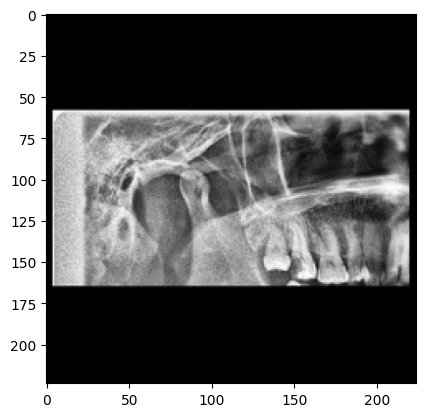

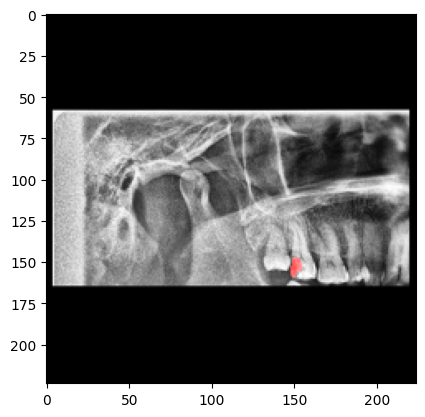

Total Loss: 0.05894317477941513

Recall: 0.9193548387096774
Precission: 0.9047619047619048
F1-Score: 0.912
Accuracy: 0.9997807716836735



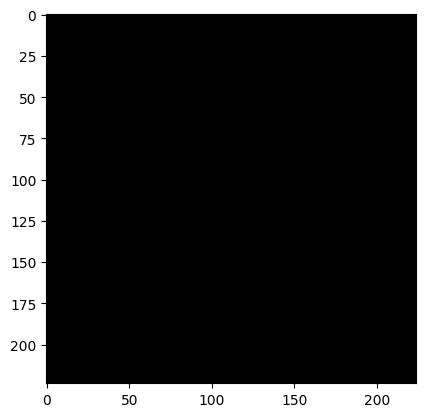

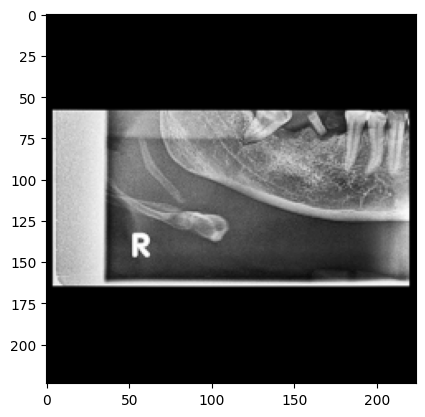

Total Loss: 0.5080257654190063

Recall: 0.0


c:\ProgramData\anaconda3\envs\u-net\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precission: 0.0
F1-Score: 0.0
Accuracy: 0.9984454719387755



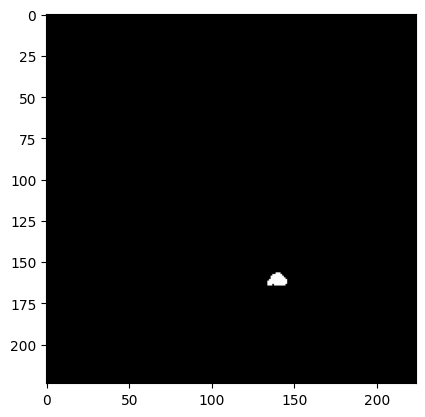

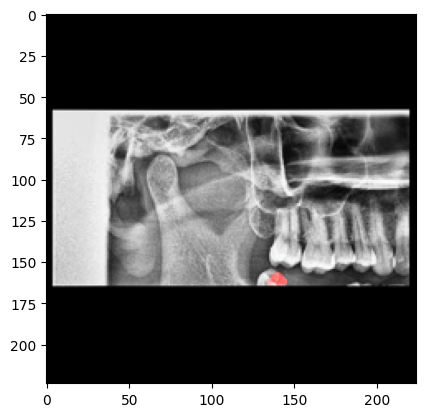

Total Loss: 0.1692454069852829

Recall: 0.8695652173913043
Precission: 0.5633802816901409
F1-Score: 0.6837606837606838
Accuracy: 0.9992625956632653



Total Loss: 0.5048210024833679

Recall: 0.0
Precission: 0.0
F1-Score: 0.0
Accuracy: 0.9977479272959183



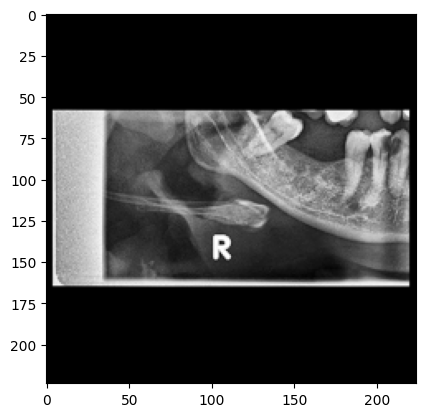

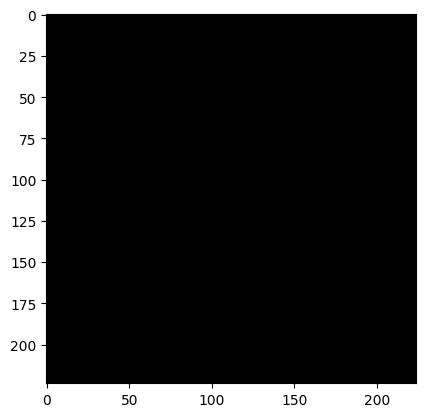

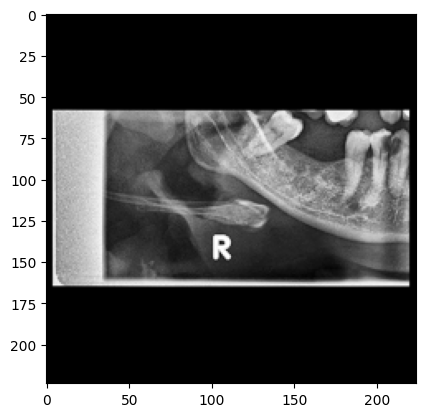

Total Loss: 0.5048847794532776

Recall: 0.0
Precission: 0.0
F1-Score: 0.0
Accuracy: 0.9985052614795918



c:\ProgramData\anaconda3\envs\u-net\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


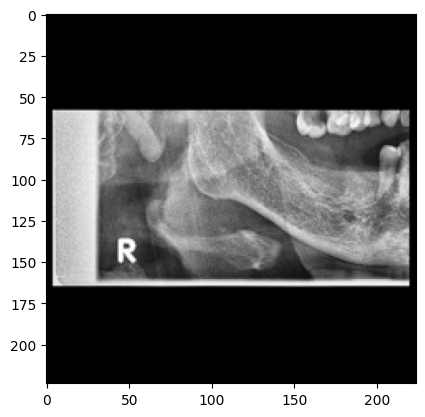

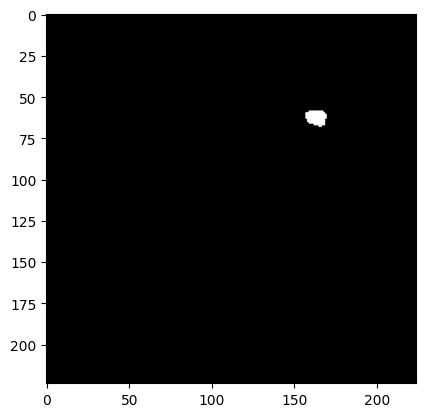

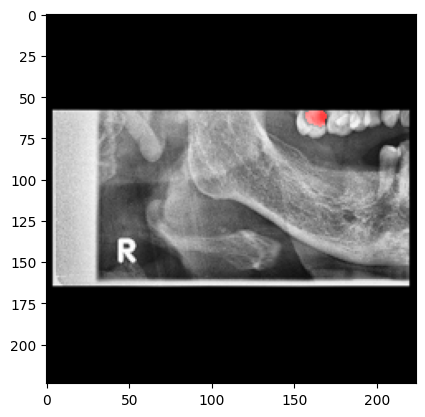

Total Loss: 0.10093127191066742

Recall: 0.8315789473684211
Precission: 0.7821782178217822
F1-Score: 0.8061224489795918
Accuracy: 0.9992426658163265



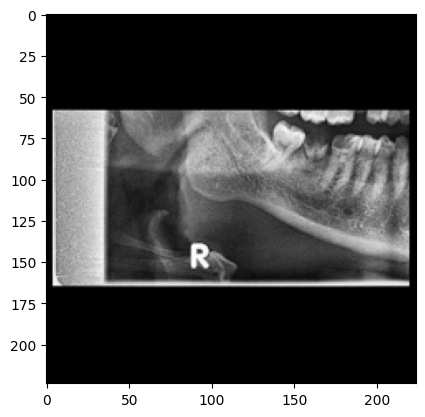

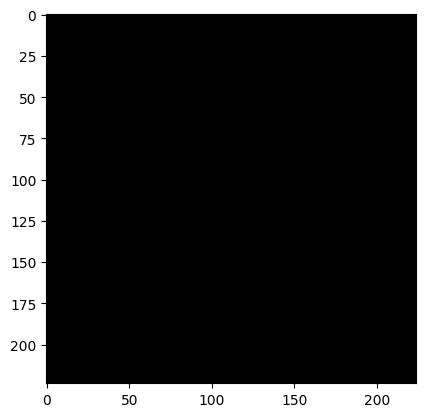

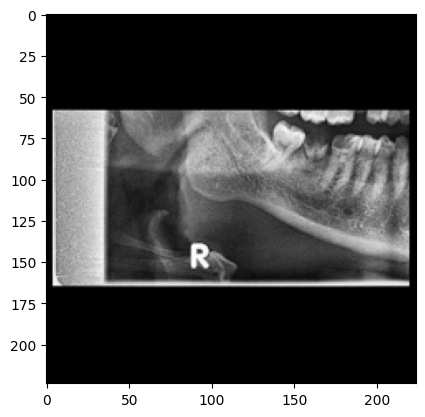

Total Loss: 0.5000829100608826

Recall: 0.0
Precission: 0.0
F1-Score: 0.0
Accuracy: 0.9986846301020408



c:\ProgramData\anaconda3\envs\u-net\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


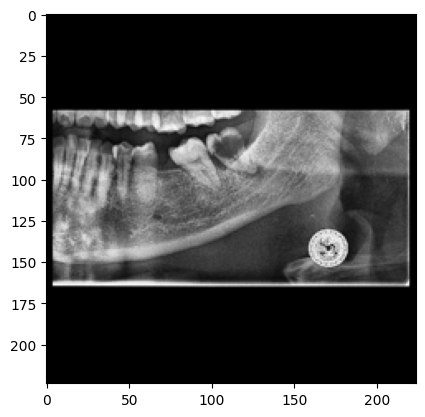

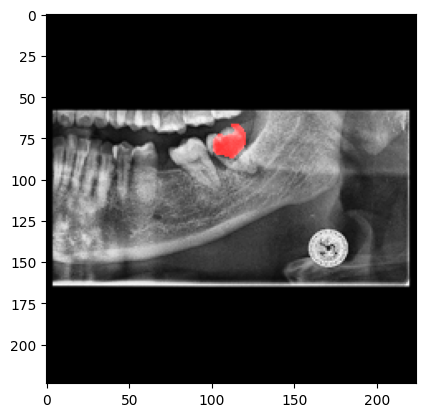

Total Loss: 0.13076235353946686

Recall: 0.9774011299435028
Precission: 0.6200716845878136
F1-Score: 0.7587719298245614
Accuracy: 0.9978077168367347



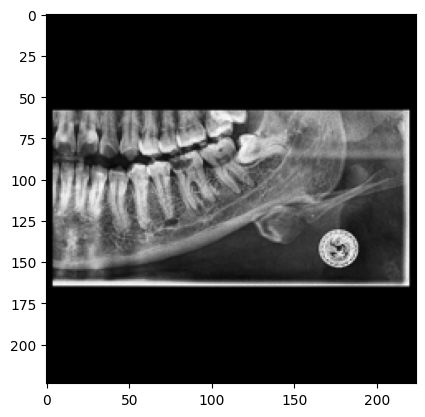

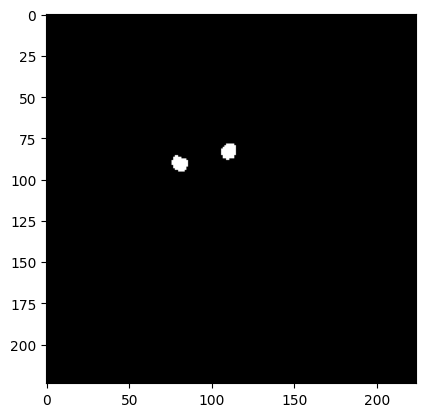

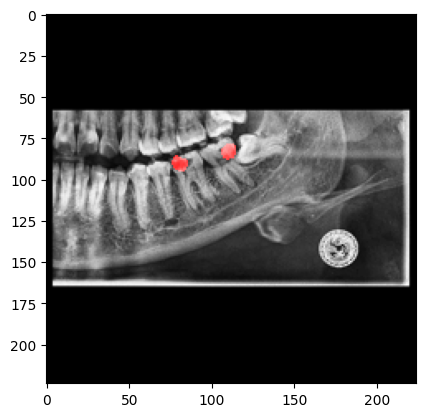

Total Loss: 0.24067920446395874

Recall: 0.6372549019607843
Precission: 0.4482758620689655
F1-Score: 0.5263157894736842
Accuracy: 0.9976682079081632



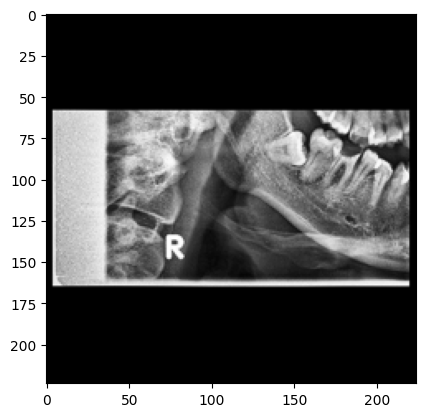

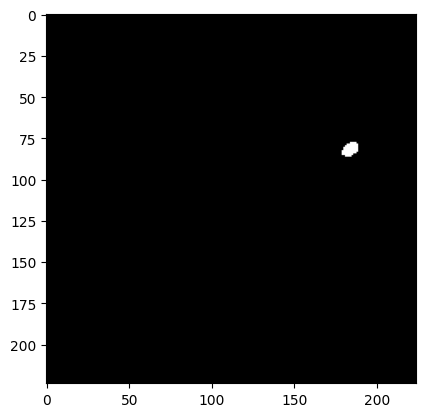

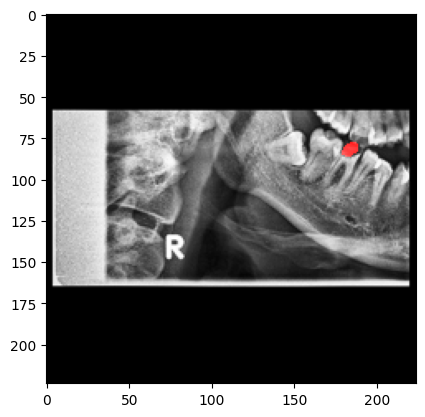

Total Loss: 0.09964685887098312

Recall: 0.725
Precission: 0.8656716417910447
F1-Score: 0.7891156462585034
Accuracy: 0.999382174744898



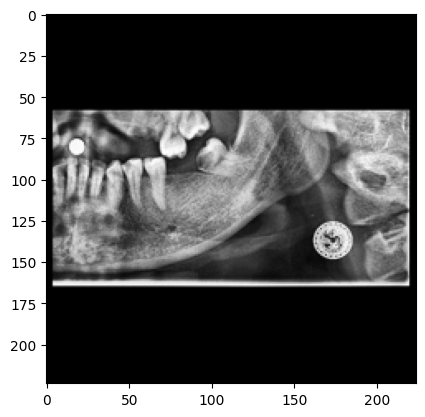

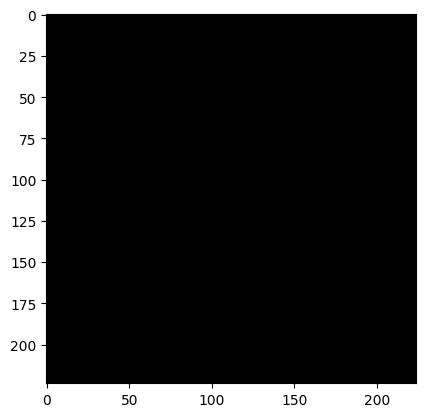

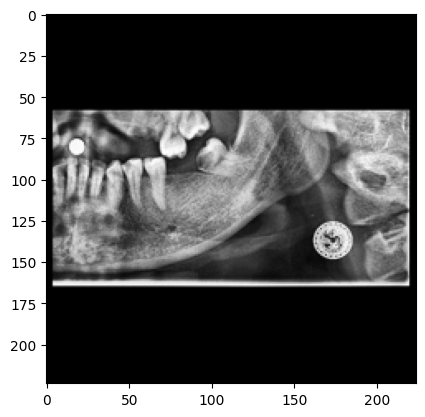

Total Loss: 0.5031326413154602

Recall: 0.0
Precission: 0.0
F1-Score: 0.0
Accuracy: 0.9984853316326531



c:\ProgramData\anaconda3\envs\u-net\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


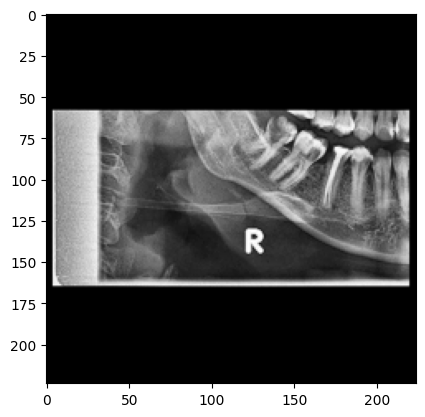

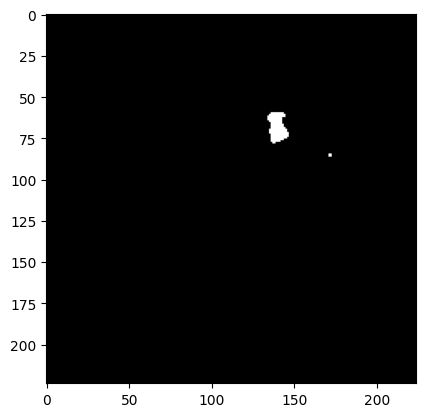

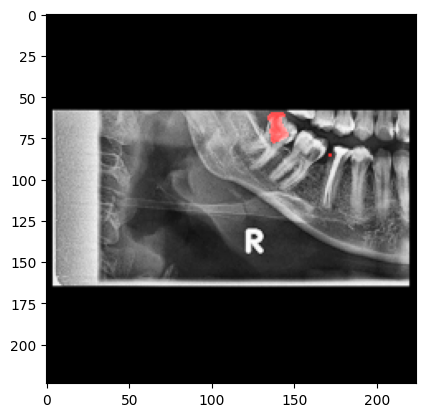

Total Loss: 0.12005161494016647

Recall: 0.9491525423728814
Precission: 0.6473988439306358
F1-Score: 0.7697594501718213
Accuracy: 0.998664700255102



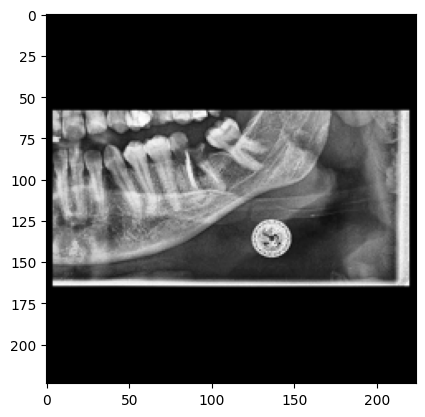

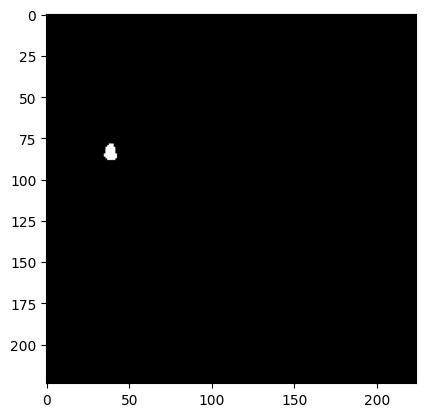

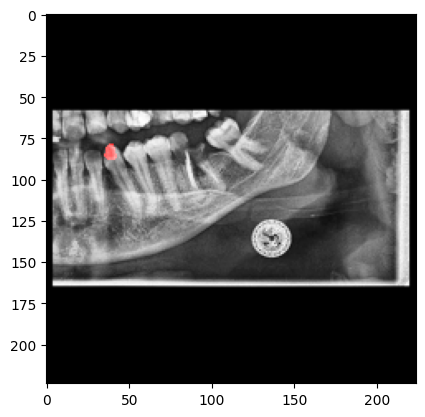

Total Loss: 0.5287596583366394

Recall: 0.0
Precission: 0.0
F1-Score: 0.0
Accuracy: 0.9939612563775511



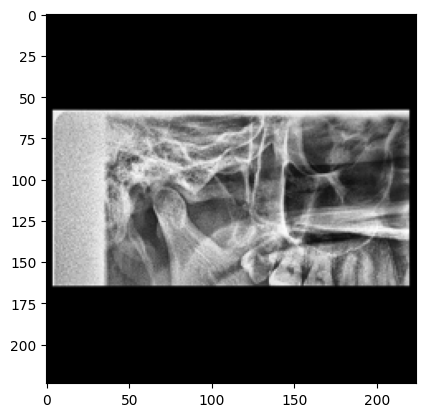

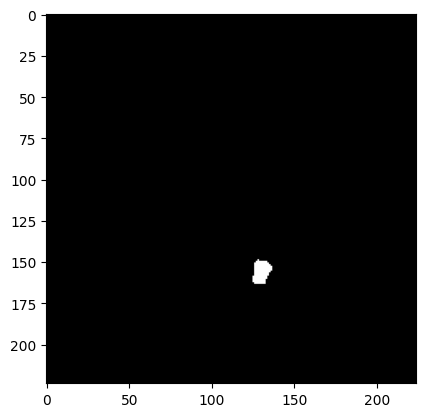

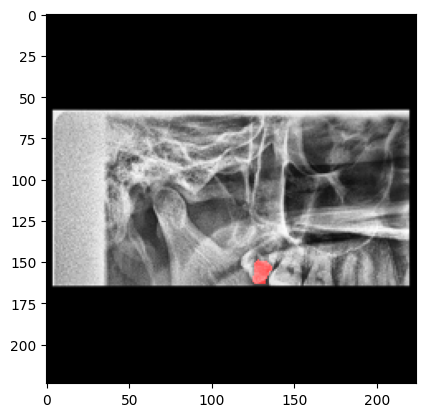

Total Loss: 0.13849210739135742

Recall: 0.6708860759493671
Precission: 0.8217054263565892
F1-Score: 0.7386759581881533
Accuracy: 0.9985052614795918



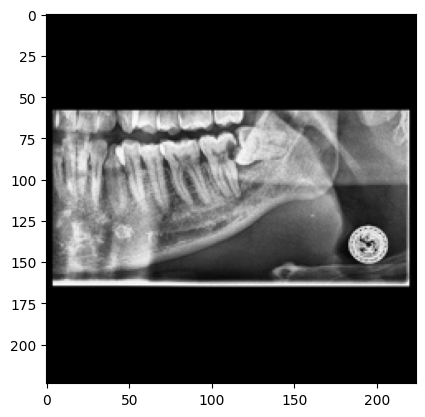

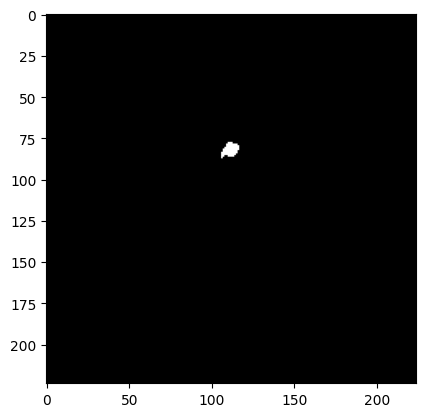

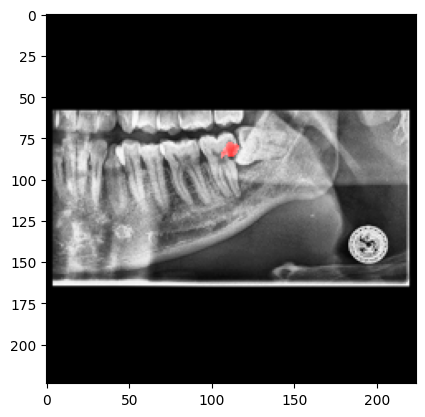

Total Loss: 0.17321783304214478

Recall: 0.7586206896551724
Precission: 0.6111111111111112
F1-Score: 0.676923076923077
Accuracy: 0.9991629464285714



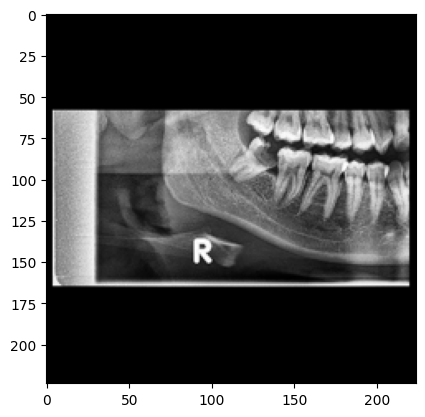

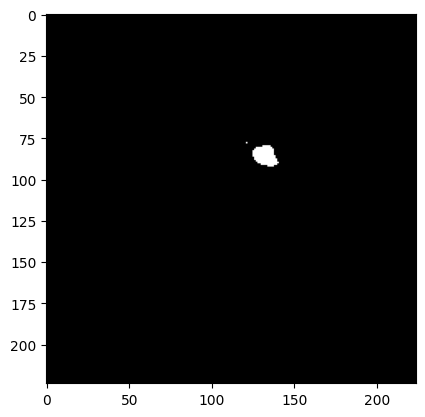

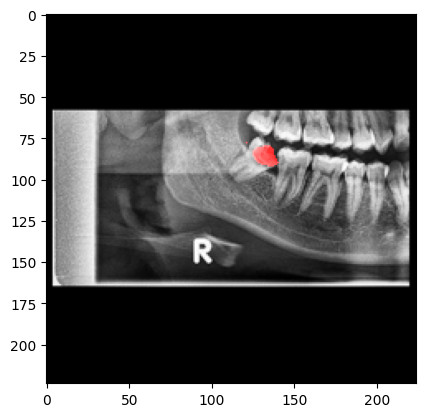

Total Loss: 0.11108555644750595

Recall: 0.9711538461538461
Precission: 0.6824324324324325
F1-Score: 0.8015873015873016
Accuracy: 0.9990035076530612



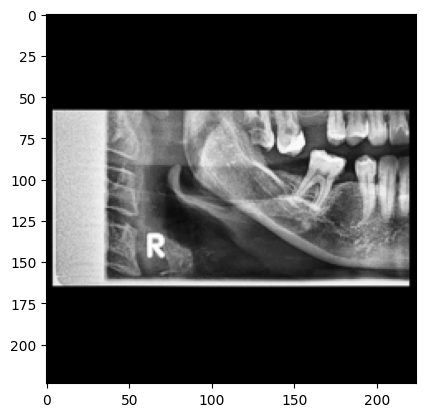

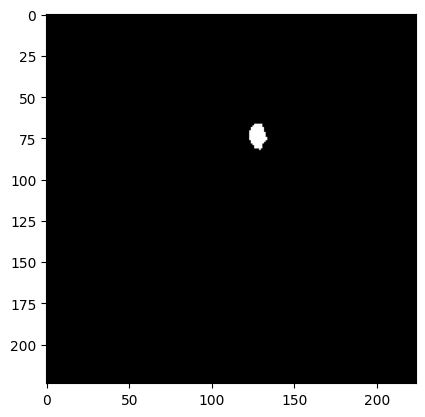

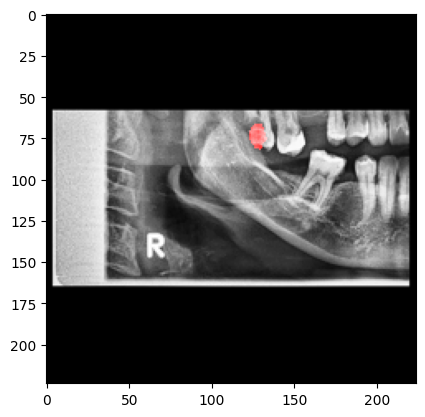

Total Loss: 0.18085429072380066

Recall: 0.563953488372093
Precission: 0.7950819672131147
F1-Score: 0.6598639455782314
Accuracy: 0.9980070153061225



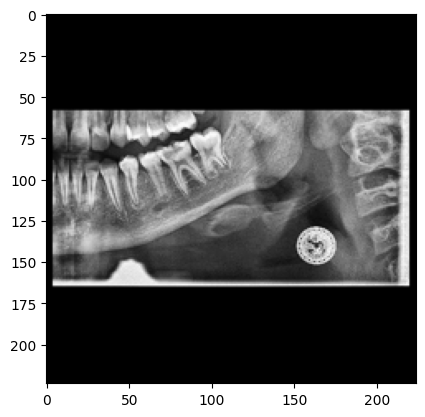

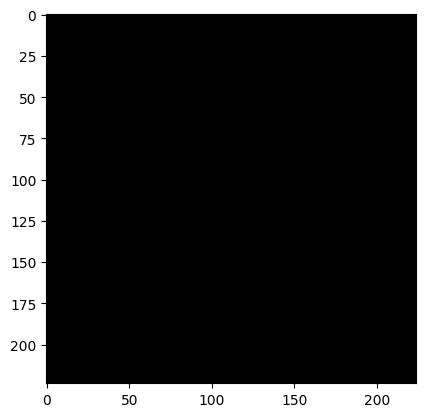

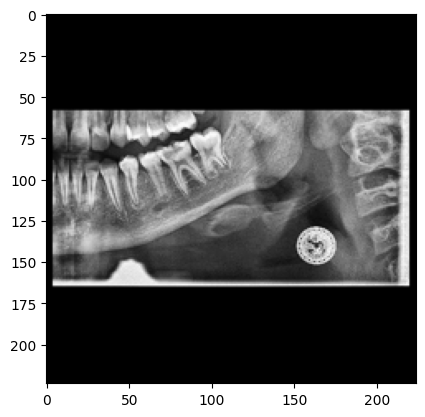

Total Loss: 0.5021334290504456

Recall: 0.0
Precission: 0.0
F1-Score: 0.0
Accuracy: 0.9987842793367347



c:\ProgramData\anaconda3\envs\u-net\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


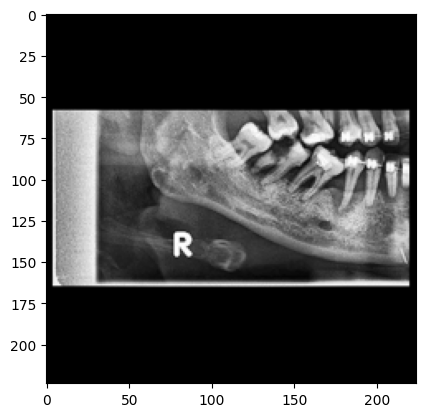

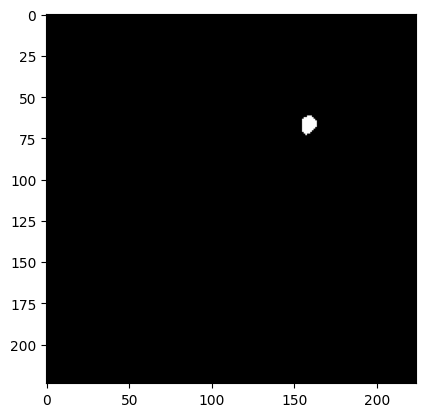

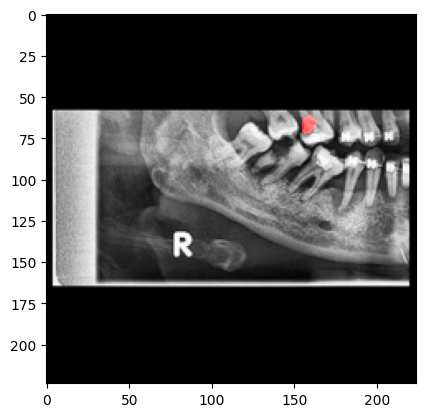

Total Loss: 0.26835930347442627

Recall: 0.3716216216216216
Precission: 0.6962025316455697
F1-Score: 0.4845814977973568
Accuracy: 0.9976682079081632



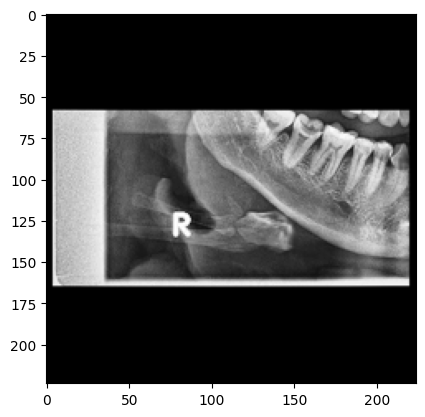

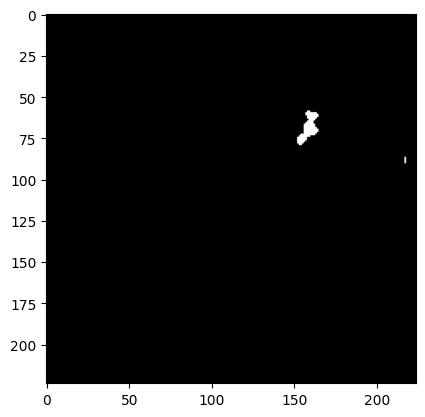

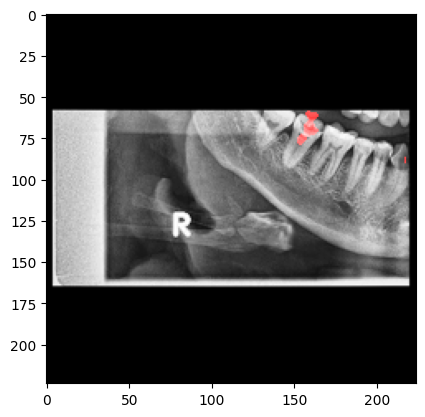

Total Loss: 0.2541694939136505

Recall: 0.5446428571428571
Precission: 0.4552238805970149
F1-Score: 0.4959349593495935
Accuracy: 0.9975286989795918



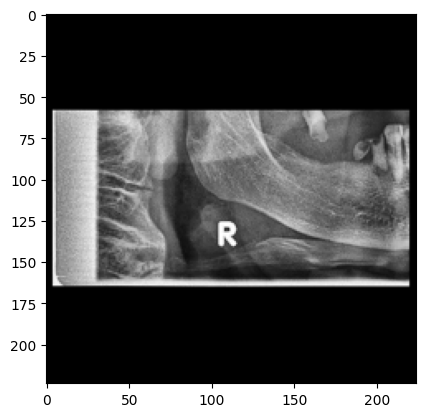

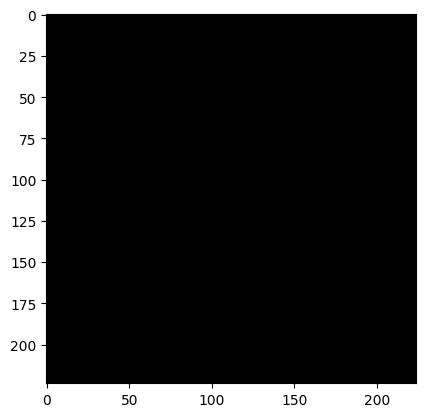

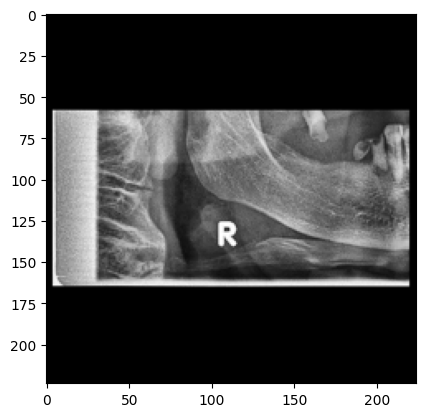

Total Loss: 0.519230306148529

Recall: 0.0
Precission: 0.0
F1-Score: 0.0
Accuracy: 0.9977678571428571



c:\ProgramData\anaconda3\envs\u-net\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


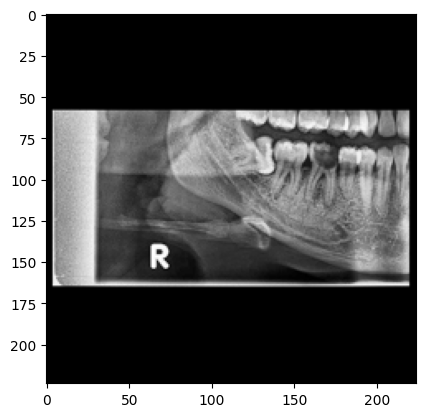

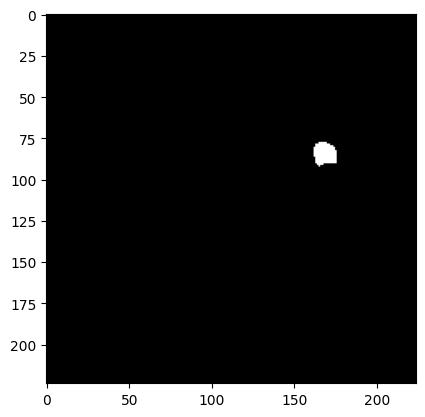

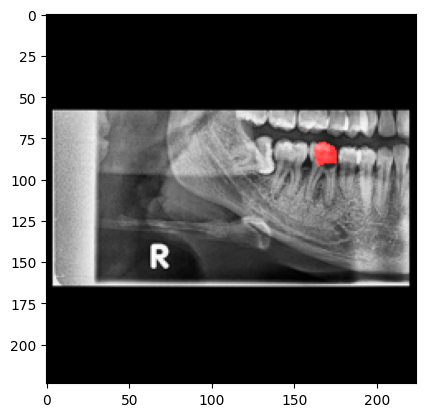

Total Loss: 0.1375371366739273

Recall: 0.7515527950310559
Precission: 0.7378048780487805
F1-Score: 0.7446153846153847
Accuracy: 0.9983458227040817

All Result Evaluation
Recall: 0.4360381172393878
Precission: 0.6275976724854531
F1-Score: 0.5145680695178054
Accuracy: 0.9984227740575397

Total Loss: bce: 0.016072, dice: 0.637166, loss: 0.326619


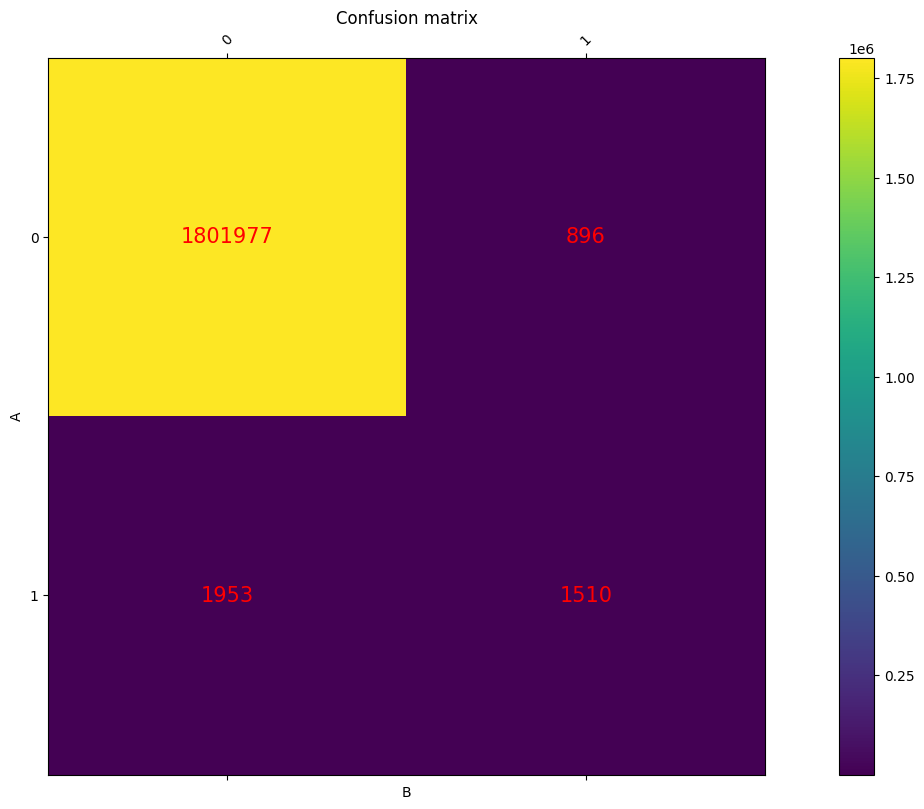

In [5]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import defaultdict
from helper import calc_loss, transform_binary

test_set = SimDataset('final-dataset/test/images', 'final-dataset/test/masking')
testloaders = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print('num_test = ', len(testloaders))

num_class = 1
model = UNet(num_class).to(device)

model.load_state_dict(torch.load('Unet_Model_Splitted_BCE&Dice.pth'))
model.eval()   # Set model to the evaluation mode

def reverse_transform(inp):
    inp = inp.transpose((1, 2, 0))
    new_inp = np.zeros((inp.shape[0],inp.shape[1],3))
    for ch in range(new_inp.shape[2]):
        for i in range(new_inp.shape[0]):
            for j in range(new_inp.shape[1]):
                if inp[i,j]>0.0:
                    new_inp[i,j,ch]=1.0
                else:
                    new_inp[i,j,ch]=0.0
    new_inp = (new_inp * 255).astype(np.uint8)
    return new_inp

def reverse_transform_input(inp):
    inp = inp.transpose((1, 2, 0))
    new_inp = np.zeros((inp.shape[0],inp.shape[1],3))
    for ch in range(new_inp.shape[2]):
        for i in range(new_inp.shape[0]):
            for j in range(new_inp.shape[1]):
                new_inp[i,j,ch]=inp[i,j]
    new_inp = (new_inp * 255).astype(np.uint8)
    return new_inp

def combine_image(input, pred):
    input = input.transpose((1, 2, 0))
    pred = pred.transpose((1, 2, 0))
    combine_image = np.zeros((224, 224, 3), dtype=input.dtype)
    for ch in range(combine_image.shape[2]):
        for i in range(combine_image.shape[0]):
            for j in range(combine_image.shape[1]):
                if ch == 0 and pred[i,j,0] > 0:
                    combine_image[i,j,ch] = 1
                else:
                    combine_image[i,j,ch] = input[i,j,0]
    combine_image = (combine_image * 255).astype(np.uint8)
    return(combine_image)

def plot_confusion_matrix(m, title='Confusion matrix'):
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    
    img = ax.matshow(m)
    plt.title(title)
    plt.colorbar(img)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["0", "1"], rotation=45)
    plt.yticks(tick_marks, ["0", "1"])

    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            plt.text(j, i, str(m[i, j]), ha='center', va='center', color='red', fontsize=15)

    plt.tight_layout()
    plt.ylabel("A")
    plt.xlabel("B")

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
metrics = defaultdict(float)
epoch_samples = len(testloaders)

predictions = []
true_labels = []

for inputs, labels in testloaders:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # Predict
    with torch.set_grad_enabled(True):
        pred = model(inputs)

    # The loss functions include the sigmoid function.
    pred_cpu = pred.data.cpu().numpy()
    inputs_cpu = inputs.data.cpu().numpy()

    # Calc loss using [BCE + Dice]
    loss = calc_loss(pred, labels, metrics)

    # Print prediction result
    plt.figure()
    for i in range(pred.shape[0]):
        plt.subplot(1, pred.shape[0],i+1)
        plt.imshow(reverse_transform_input(inputs_cpu[i]))
    plt.show()
    plt.figure()
    for i in range(pred.shape[0]):
        plt.subplot(1, pred.shape[0],i+1)
        plt.imshow(reverse_transform(pred_cpu[i]))
    plt.show()
    plt.figure()
    for i in range(pred.shape[0]):
        plt.subplot(1, pred.shape[0],i+1)
        plt.imshow(combine_image(inputs_cpu[i], pred_cpu[i]))
    plt.show()

    # Print total loss
    print("Total Loss: {}\n" .format(loss.item()))

    # Flating array
    y_target_2d = labels.cpu().numpy().reshape(-1, 1).astype(int)
    y_predicted_2d = transform_binary(pred_cpu).reshape(-1, 1).astype(int)
    np_true_label = np.array(y_target_2d).flatten()
    np_prediction = np.array(y_predicted_2d).flatten()
    predictions.extend(y_predicted_2d.tolist())
    true_labels.extend(y_target_2d.tolist())

    print('Recall: {}' .format(recall_score(np_true_label, np_prediction, average="binary")))
    print('Precission: {}' .format(precision_score(np_true_label, np_prediction, average="binary")))
    print('F1-Score: {}' .format(f1_score(np_true_label, np_prediction, average="binary")))
    print('Accuracy: {}\n' .format(accuracy_score(np_true_label, np_prediction)))

np_true_labels = np.array(true_labels).flatten()
np_predictions = np.array(predictions).flatten()
confusion_m = confusion_matrix(np_true_labels, np_predictions)
plot_confusion_matrix(confusion_m)

print('All Result Evaluation')
print('Recall: {}' .format(recall_score(np_true_labels, np_predictions, average="binary")))
print('Precission: {}' .format(precision_score(np_true_labels, np_predictions, average="binary")))
print('F1-Score: {}' .format(f1_score(np_true_labels, np_predictions, average="binary")))
print('Accuracy: {}\n' .format(accuracy_score(np_true_labels, np_predictions)))

# Print loss
print_metrics(metrics, epoch_samples, 'Total Loss')